# Image Classification, Cat and Dog

Classification has four steps
1. Setup
2. Pre-processing - data preparation
3. Model Define
4. Training
5. Post-processing - visualization

In [ ]:
# setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# for data pre-processing
import os

# for visualize data
import matplotlib.pyplot as plt

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   104M      0  0:00:07  0:00:07 --:--:--  108M


###### 2. Pre-processing - filter out corrupted images

filter out badly-encoded images


In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


###### 2. Pre-processing - generates a dataset for training and validation

180 x 180 image, 
batch size = 32


make a training data and validation data

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


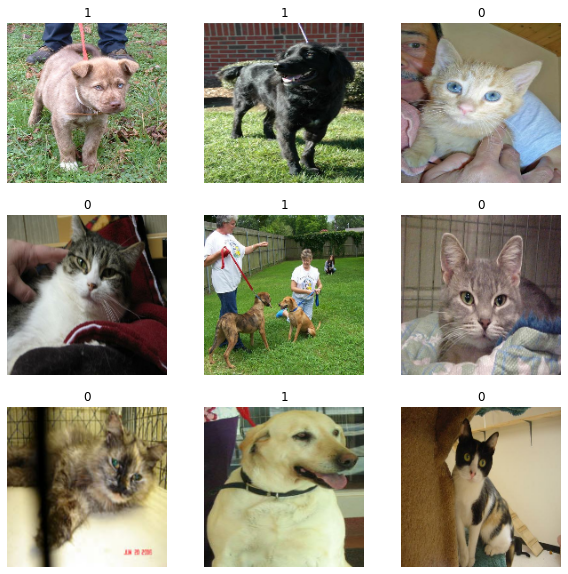

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

###### 3. Model define

use some related alorithms such as relu, sigmoid, softmax, dropout


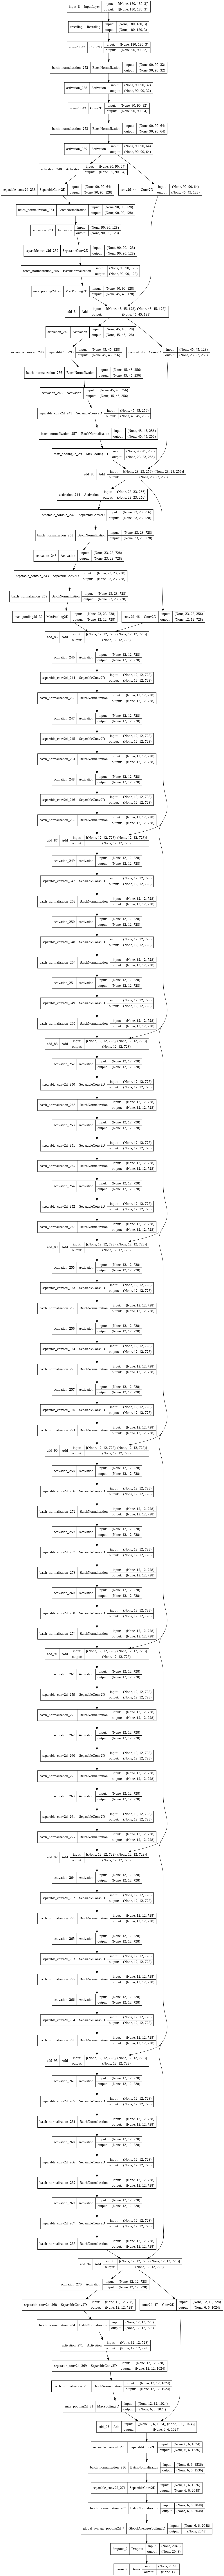

In [ ]:
def make_model(input_shape, num_classes):

    inputs = tf.keras.Input(shape=input_shape)

    # Entry flow
    x = inputs
    x = layers.Conv2D(32, 3, strides=2, padding= "same" )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    #  Middle flow  #

    for i in range(8):

      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(728, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(728, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(728, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.add([x, residual])
      previous_block_activation = x


    #  Exit flow  #

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(728, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    residual = layers.Conv2D(1024, 1, strides=2, padding="same")(
      previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual

    x = layers.SeparableConv2D(1536, 3, padding="same", activation = 'relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.SeparableConv2D(2048, 3, padding="same", activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation= 'sigmoid' )(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 90, 90, 32)   896         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_108 (Batch  (None, 90, 90, 32)  128         ['conv2d_18[0][0]']              
 Normalization)                                                                                   
                                                                                            

In [ ]:
import sys
sys.stdout = open('/content/drive/MyDrive/과제/output.txt','a')

###### 4. Training

Model training for cat and dog

In [ ]:
epochs = 50
# 기본적인 경우 변경 #

path = '/content/drive/MyDrive/과제'

file_name = "ckeckpointer.ckpt"
callbacks_ = keras.callbacks.ModelCheckpoint(os.path.join(path, file_name), 
                            save_weights_only=True, 
                            save_best_only=True, 
                            monitor='val_loss', 
                            verbose=1
                            )

model.compile(
    optimizer=keras.optimizers.Adam(0.005),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

def scheduler(epoch, lr):
  if epoch == 0:
    return lr
  elif epoch %2 == 0:
    return 0.94*lr
  else :
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(
    train_ds, epochs=epochs, callbacks= [callbacks_,lr_scheduler], validation_data=val_ds,
)


Epoch 1/50
586/586 [==============================] - ETA: 0s - loss: 0.7304 - accuracy: 0.5713
Epoch 00001: val_loss improved from inf to 3.68682, saving model to /content/drive/MyDrive/과제/ckeckpointer.ckpt
586/586 [==============================] - 178s 296ms/step - loss: 0.7304 - accuracy: 0.5713 - val_loss: 3.6868 - val_accuracy: 0.5043 - lr: 0.0050
Epoch 2/50
586/586 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.6467
Epoch 00002: val_loss improved from 3.68682 to 1.04280, saving model to /content/drive/MyDrive/과제/ckeckpointer.ckpt
586/586 [==============================] - 173s 295ms/step - loss: 0.6306 - accuracy: 0.6467 - val_loss: 1.0428 - val_accuracy: 0.5203 - lr: 0.0050
Epoch 3/50
586/586 [==============================] - ETA: 0s - loss: 0.5786 - accuracy: 0.6976
Epoch 00003: val_loss did not improve from 1.04280
586/586 [==============================] - 171s 292ms/step - loss: 0.5786 - accuracy: 0.6976 - val_loss: 1.0929 - val_accuracy: 0.506

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###### 5. Inference with new data

try to 6779.jpg for classification

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 93.97 percent cat and 6.03 percent dog.
